In [1]:
#download data from instructor's storage
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2020-07-30 21:04:42--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c08::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   163MB/s    in 0.9s    

2020-07-30 21:04:43 (163 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



Importing zipfile to extract the zip folder.

In [2]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

In [4]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

In [5]:
train_horse_dir

'/tmp/horse-or-human/horses'

Now, let's see what the filenames look like in the `horses` and `humans` training directories:

In [6]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse35-8.png', 'horse48-9.png', 'horse19-0.png', 'horse49-9.png', 'horse06-1.png', 'horse43-1.png', 'horse44-0.png', 'horse04-2.png', 'horse01-3.png', 'horse37-2.png']
['human08-00.png', 'human15-24.png', 'human17-19.png', 'human16-26.png', 'human13-27.png', 'human04-03.png', 'human16-03.png', 'human15-07.png', 'human05-21.png', 'human17-03.png']


Let's find out the total number of horse and human images in the directories:

In [7]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


Preview some pix:

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 4
ncols = 4

pic_index=0

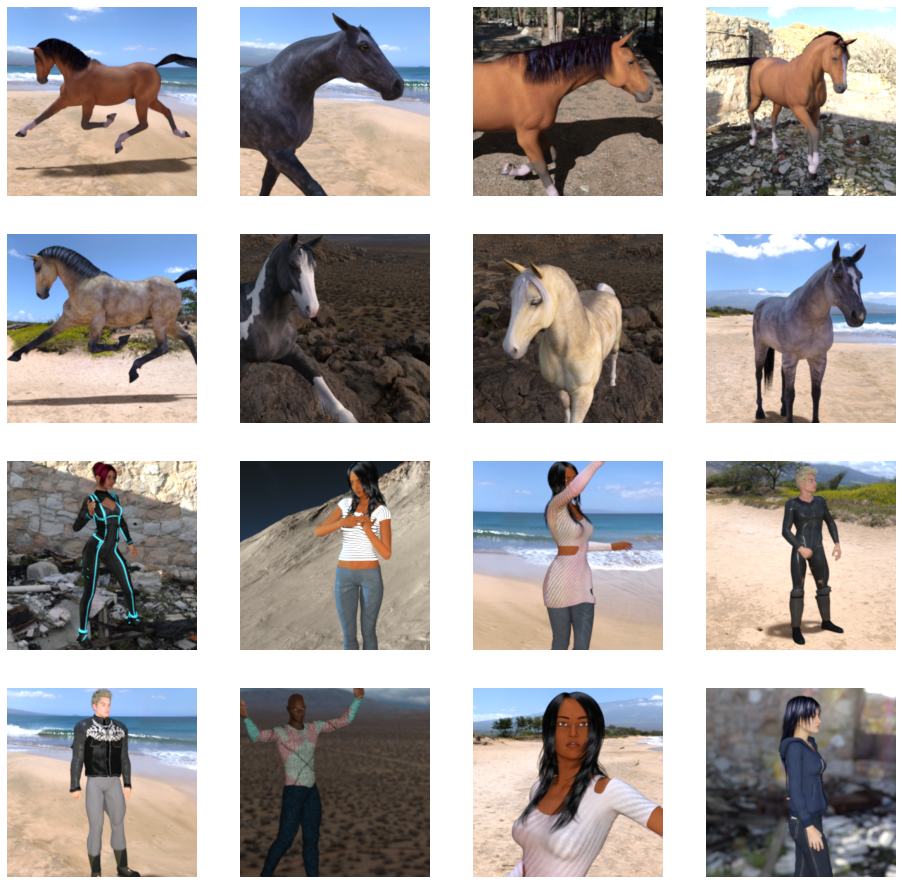

In [11]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# Model Building

In [12]:
import tensorflow as tf

In [14]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
                             tf.keras.layers.MaxPooling2D(2, 2),

                             tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                             tf.keras.layers.MaxPooling2D(2,2),

                             tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                             tf.keras.layers.MaxPooling2D(2,2),

                             tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                             tf.keras.layers.MaxPooling2D(2,2),

                             tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                             tf.keras.layers.MaxPooling2D(2,2),

                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 33, 33, 64)        3

In [16]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 300x300 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit`, `evaluate_generator`, and `predict_generator`.

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.


In [19]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 4s 555ms/step - loss: 0.8675 - accuracy: 0.5184
Epoch 2/15
8/8 [==============================] - 6s 716ms/step - loss: 0.6713 - accuracy: 0.6796
Epoch 3/15
8/8 [==============================] - 5s 622ms/step - loss: 0.8080 - accuracy: 0.7764
Epoch 4/15
8/8 [==============================] - 6s 699ms/step - loss: 0.4682 - accuracy: 0.8193
Epoch 5/15
8/8 [==============================] - 6s 703ms/step - loss: 0.2224 - accuracy: 0.9209
Epoch 6/15
8/8 [==============================] - 5s 610ms/step - loss: 0.2103 - accuracy: 0.9232
Epoch 7/15
8/8 [==============================] - 6s 700ms/step - loss: 0.8034 - accuracy: 0.8457
Epoch 8/15
8/8 [==============================] - 5s 619ms/step - loss: 0.1093 - accuracy: 0.9622
Epoch 9/15
8/8 [==============================] - 5s 614ms/step - loss: 0.0933 - accuracy: 0.9677
Epoch 10/15
8/8 [==============================] - 5s 613ms/step - loss: 0.0426 - accuracy: 0.9867
Epoch 11/15
8/8 [==

###Running the Model

Let's now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, it will then upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

In [21]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
 

Saving girl-3551832_640.jpg to girl-3551832_640.jpg
Saving white-horse-3010129_640.jpg to white-horse-3010129_640.jpg
[0.]
girl-3551832_640.jpg is a horse
[0.]
white-horse-3010129_640.jpg is a horse


### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


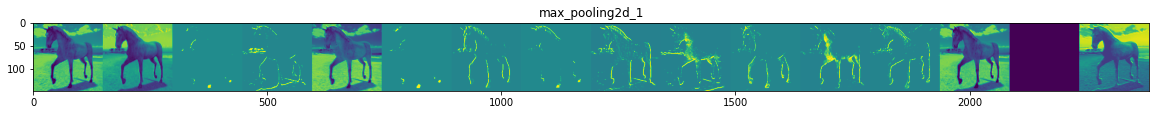

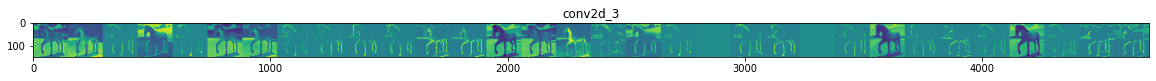

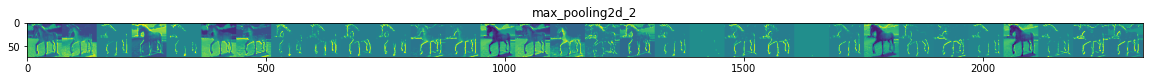

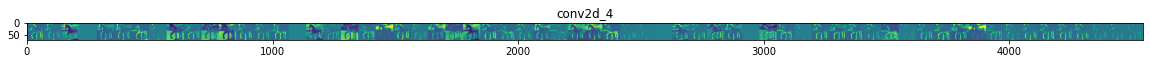

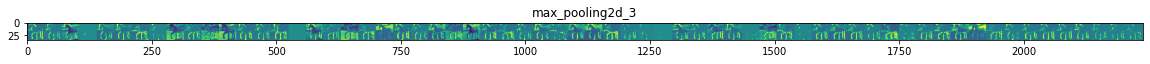

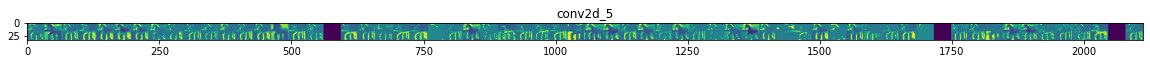

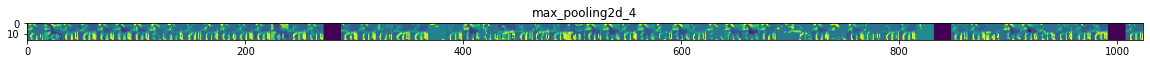

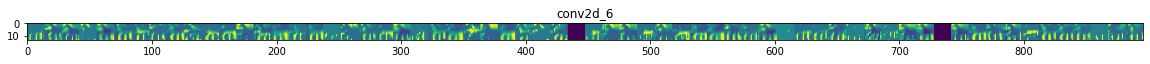

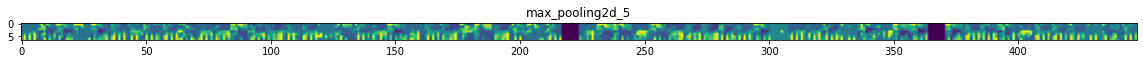

In [24]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')